#Figure 3
We show that kernels can be optimized as hyperparameters by minimizing cross-validation loss with a quasi-Newton method. The resulting kernels perform as well as the best deep ReLU kernels.

# Imports and setup

In [ ]:
!pip install -q git+https://www.github.com/google/neural-tangents
!sudo apt-get install texlive-latex-recommended
!sudo apt install texlive-latex-extra
!sudo apt install dvipng
!sudo apt install cm-super dvipng
!pip install pmlb
!pip install cifar10_web

import numpy as base_np
import pandas as pd
import cvxopt

import jax.numpy as np
import jax.nn
from jax import random
from jax.experimental import optimizers
from jax.api import jit, grad, vmap
from jax.ops import *
from jax.config import config
config.update("jax_enable_x64", True)

import neural_tangents as nt
from neural_tangents import stax

from scipy.special import factorial, factorial2
from sklearn.model_selection import train_test_split

from pmlb import fetch_data
import cifar10_web

import matplotlib.pyplot as plt

np.set_printoptions(precision=4, linewidth=200)

key = random.PRNGKey(17)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13
  lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base
Suggested packages:
  fonts-noto poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper gv
  | postscript-viewer perl-tk xpdf-reader | pdf-viewer texlive-latex-base-doc
  texlive-latex-recommended-doc texlive-pstricks
The following NEW packages will be installed:
  fonts-d

In [ ]:
from tqdm import tqdm
from jax import device_put
import csv
import os
from scipy.optimize import minimize
import time
from scipy.special import softmax
from sklearn.model_selection import KFold
from copy import deepcopy as copy
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Shallow Learning')

# Datasetup

Load the CIFAR-10 data set and normalize the input data so that the magnitude is $\sqrt{n_0}$ where $n_0$ is the dimension of the input data.

In [ ]:
def get_cifar10(n_train=None):
  train_X, train_y, test_X, test_y = cifar10_web.cifar10(path=None)

  # NORMALIZE GLOBALLY
  train_mean = train_X.mean()
  train_std = train_X.std()
  train_X = (train_X - train_mean)/train_std
  test_X = (test_X - train_mean)/train_std
  # NORMALIZE LOCALLY
  train_X = train_X/((train_X**2).mean(axis=1)**.5)[:,None]
  test_X = test_X/((test_X**2).mean(axis=1)**.5)[:,None]

  if n_train is not None:
    train_X = train_X[:n_train]
    train_y = train_y[:n_train]

  return train_X, train_y, test_X, test_y

We work with the first 10k images of the training set due to limitations in memory.

In [ ]:
train_X, train_y, test_X, test_y = get_cifar10(n_train=10000)    # Train - 50k, Test - 10k. Each image is 32 x 32 x 3
dataset_cifar10 = train_X, train_y, test_X, test_y

Downloaded cifar-10-binary.tar.gz to /root/data/cifar10


# Deep nets and fitting functions

In [ ]:
def psd_poly_fit(xs, fs, deg=5):
  Q = base_np.zeros((deg+1, deg+1))
  p = base_np.zeros((deg+1,))
  G = -1*base_np.eye(deg+1)
  h = 0*p

  for i in range(deg + 1):
    for j in range(deg + 1):
      Q[i][j] = 2*(xs**(i+j)).sum()
  for i in range(deg + 1):
    p[i] = -2*((xs**i)*fs).sum()
  
  Q = cvxopt.matrix(Q)
  p = cvxopt.matrix(p)
  G = cvxopt.matrix(G)
  h = cvxopt.matrix(h)
  
  cvxopt.solvers.options['show_progress'] = False
  sol = cvxopt.solvers.qp(Q, p, G, h)

  return base_np.array(sol['x']).flatten()

def poly_coeffs_to_lambda_fn_string(c_alpha, factorials=True):
  output = "lambda z: "
  for i in range(len(c_alpha)):
    coeff = c_alpha[i]/factorial(i) if factorials else c_alpha[i]
    if coeff != 0:
      output += str(coeff) + "*z**" + str(i) + " + "
  return(output[:-3])

def phi_from_kernel_fn_coeffs(desired_coeffs):
  deg = len(desired_coeffs)
  
  desired_coeffs *= (np.array(np.abs(desired_coeffs) > 10**-3))

  # construct matrix for going from K (i.e. a_gamma) to phi (i.e. c_alpha)
  Minv = [[(-1)**((col - row)/2)/factorial2(col - row)
          if (col >= row)*((col + row)%2 == 0)
          else 0
          for col in range(deg + 1)]
          for row in range(deg + 1)]
  Minv = np.array(Minv)

  a_gamma = [desired_coeffs[gamma]*factorial(gamma) if gamma < len(desired_coeffs) else 0 for gamma in range(len(Minv))]
  b_gamma = np.array(a_gamma)**.5
  c_alpha = np.matmul(Minv, np.array(b_gamma))

  phi_def_string = poly_coeffs_to_lambda_fn_string(c_alpha)
  phi = eval(phi_def_string)
  print()
  print('phi =', phi_def_string)
  print()

  return phi

In [ ]:
def get_net_functions(d_in, width, d_out, n_hidden_layers=1, phi=None, deg=40, centered=False, W_std=None, b_std=None):
    global key

    init_fn, apply_fn_uncentered, kernel_fn = None, None, None

    # if there's a phi, make a net with activation function phi
    if phi is not None and phi != 'relu':
      if phi == 'erf':
        W_std = W_std if W_std is not None else 2
        b_std = b_std if b_std is not None else 0
        layers = [stax.Dense(width, W_std=W_std, b_std=b_std), stax.Erf()]*n_hidden_layers
        layers += [stax.Dense(d_out, W_std=1, b_std=0)]
        init_fn, apply_fn_uncentered, kernel_fn = stax.serial(*layers)
      else:   # For a pointwise defined nonlinearity, we must have sigma_w, sigma_b = (1,0).
        W_std = W_std if W_std is not None else 1
        b_std = b_std if b_std is not None else 0
        layers = [stax.Dense(width, W_std=W_std, b_std=b_std), stax.ElementwiseNumerical(fn=phi, deg=deg)]*n_hidden_layers
        layers += [stax.Dense(d_out, W_std=1, b_std=0)]
        init_fn, apply_fn_uncentered, kernel_fn = stax.serial(*layers)

    # otherwise, make a relu net
    else:
      W_std = W_std if W_std is not None else 1.5
      b_std = b_std if b_std is not None else 0.05
      layers = [stax.Dense(width, W_std=W_std, b_std=b_std), stax.Relu()]*n_hidden_layers
      layers += [stax.Dense(d_out, W_std=1, b_std=0)]
      init_fn, apply_fn_uncentered, kernel_fn = stax.serial(*layers)

    key, net_key = random.split(key)
    _, initial_params = init_fn(net_key, (-1, d_in))
    apply_fn = jit(apply_fn_uncentered) if not centered else jit(lambda params, x: apply_fn_uncentered(params, x) - apply_fn_uncentered(initial_params, x))

    return init_fn, apply_fn, kernel_fn, initial_params

In [ ]:
def get_batched_kernel_fn(kernel_fn, k_batch_size=100):
  def batched_kernel_fn(x1, x2, get=None):
    x2 = x1 if x2 is None else x2
    get = get[0] if get in [('nngp',),('ntk',)] else get
    kernel_fn_jit = jit(lambda x1,x2: kernel_fn(x1, x2, get))
    # subkernels = [kernel_fn(x1, x2[k_batch_size*i:min(k_batch_size*(i+1), x2.shape[0])], get=get) for i in range(int(np.ceil(x2.shape[0]/k_batch_size)))]
    subkernels = [kernel_fn_jit(x1, x2[k_batch_size*i:min(k_batch_size*(i+1), x2.shape[0])]) for i in range(int(np.ceil(x2.shape[0]/k_batch_size)))]
    output = np.concatenate(subkernels, axis=1)
    return output
  return batched_kernel_fn

mse = lambda y_hat, y_true: 0.5 * ((y_hat - y_true) ** 2).sum(axis=1).mean()
percent_correct = jit(lambda y_hat, y_true: 100*(np.argmax(y_hat, axis=1) == np.argmax(y_true, axis=1)).mean())

# Functions for Optimizing Kernels

Objective function to minimize. Calculate loss, accuracy, and cross entropy using folds of the training data, and return the one specified by 'type'.

In [ ]:
mse = jit(lambda y_hat, y_true: 0.5 * ((y_hat - y_true) ** 2).sum(axis=1).mean())
cross_entropy = jit(lambda y_hat, y_true: -1* np.einsum('ji,ji', y_true, np.log(jax.nn.softmax(y_hat, axis=1))))

def kernel_parameters_to_valmetric(k_coeffs, dataset=dataset_cifar10, type=0, test=False):
  train_X, train_y, test_X, test_y = dataset
  d_in = train_X.shape[1]
  d_out = train_y.shape[1]

  k_poly = eval(poly_coeffs_to_lambda_fn_string(k_coeffs, factorials=False))
  current_kernel = lambda x1, x2, get=None: k_poly(np.matmul(x1, x2.transpose())/d_in)
  batched_kernel_fn = get_batched_kernel_fn(current_kernel, k_batch_size=1000)
  
  kfloss_shallow = 0
  kfacc_shallow = 0
  kfce_shallow = 0
  
  kf = KFold(n_splits=4, shuffle=False)
  for train_index, val_index in kf.split(train_X):
    predict_fn = nt.predict.gradient_descent_mse_ensemble(batched_kernel_fn, train_X[train_index], train_y[train_index])
    inf_width_test_preds = predict_fn(x_test=train_X[val_index], get='nngp', compute_cov=False)

    kfloss_shallow = mse(inf_width_test_preds, train_y[val_index])
    kfacc_shallow = percent_correct(inf_width_test_preds, train_y[val_index])
    kfce_shallow = cross_entropy(inf_width_test_preds, train_y[val_index])

  #print("K=4 fold, shallow (nngp)      	  loss: {:9.5f}".format(kfloss_shallow), "\t\t\tacc: {:7.2f}".format(kfacc_shallow), "\t\t\tce: {:7.2f}".format(kfce_shallow/train_y.shape[0]))

  if test:
    predict_fn = nt.predict.gradient_descent_mse_ensemble(batched_kernel_fn, train_X, train_y)
    inf_width_test_preds = predict_fn(x_test=test_X, get='nngp', compute_cov=False)

    testloss_shallow = mse(inf_width_test_preds, test_y)
    testacc_shallow = percent_correct(inf_width_test_preds, test_y)
    testce_shallow = cross_entropy(inf_width_test_preds, test_y) / test_y.shape[0]
    print("Test, shallow      	  loss: {:9.5f}".format(testloss_shallow), "\t\t\tacc: {:7.2f}".format(testacc_shallow), "\t\t\tce: {:7.2f}".format(testce_shallow))
    return testloss_shallow, testacc_shallow
  if type == 0:
    return kfloss_shallow
  elif type == 1:
    return -1*kfacc_shallow
  elif type == 2:
    return kfce_shallow

Fit a polynomial to the provided kernel function. If specified, put extra weight on the endpoints to improve the fits in the 'NTK' case where the slope at $\xi=1$ is infinite.

In [ ]:
def kernel_polynomial(kernel_fn, k_type, deg=10, n_sample_pts=1000, weight_on_endpts=.1):
  d_in = 2
  n_sample_pts = n_sample_pts
  xis = np.linspace(1,-1,n_sample_pts)

  # if weighting the endpoints higher, add more -1s and +1s to xis
  if weight_on_endpts > 0:
    n_interior_pts = int(n_sample_pts*(1 - 2*weight_on_endpts))
    n_endpts = int(n_sample_pts*weight_on_endpts)
    xis = np.linspace(1, -1, n_interior_pts + 2)
    xis = np.concatenate([np.array([1]*(n_endpts - 1)), xis, np.array([-1]*(n_endpts - 1))])

  sines = (1 - xis**2)**.5
  u0 = index_update(np.zeros(d_in), 0, 1)
  u1 = index_update(np.zeros(d_in), 1, 1)
  xs = np.outer(xis, u0) + np.outer(sines, u1)
  xs = (d_in**.5)*xs

  Ks = kernel_fn(xs[0:1], xs, k_type)[0]

  k_coeffs = psd_poly_fit(xis, Ks, deg=deg)

  return k_coeffs, Ks #eval(poly_coeffs_to_lambda_fn_string(k_coeffs, factorials=False))

def get_empirical_K_coeffs(dataset, degree):
  train_X, train_y, test_X, test_y = dataset
  d_in = train_X.shape[1]
  d_out = train_y.shape[1]

  _, _, _, xi_values, output_similarity = bin_outputs_scalar(train_X, train_y, 100)
  k_coeffs = psd_poly_fit(xi_values, output_similarity, deg=degree)
  print('Empirical kernel coefficients: ', k_coeffs)
  return k_coeffs

def get_infinite_width_K_coeffs(dataset, degree, k_type, depth, activation, n_sample_points=1000, weight_on_endpoints=0.1):
  train_X, train_y, test_X, test_y = dataset
  assert activation in ['erf', 'relu']
  assert k_type in ['nngp', 'ntk']
  if activation == 'erf':
    W_std=1.5
    b_std=.3
  else:
    W_std=None
    b_std=.1

  _, _, kernel_fn, _ = get_net_functions(2, 1000, 1, n_hidden_layers=depth, phi=activation, W_std=W_std, b_std=b_std)
  k_coeffs, Ks = kernel_polynomial(kernel_fn, k_type, degree, n_sample_pts=n_sample_points, weight_on_endpts=weight_on_endpoints)
  print('Infinite kernel coefficients: ', k_coeffs)
  return k_coeffs, Ks

# Optimizing Random and Infinite Kernels



## Random Kernels

In [ ]:
random_kernels = []
optimized_kernels = []

for _ in range(10):
  #params_guess = base_np.random.rand(base_np.random.randint(3,22))
  #params_guess = base_np.pad(params_guess, (0, 21 - len(params_guess)), 'constant', constant_values=(0))
  params_guess = base_np.random.rand(20+1)*(base_np.random.rand(20+1) < .2)   # generate degree 20 polynomial and set 80% of the coefficients to 0.
  print('Initial Guess:', params_guess)
  initial_loss, initial_acc = kernel_parameters_to_valmetric(params_guess, dataset_cifar10, type=0, test=True)
  random_kernels.append((params_guess, initial_loss, initial_acc))

  print()
  
  options = {'eps': 1.e-3, 'gtol': 1e-6, 'disp': True, 'maxiter': 150}
  t1 = time.time()
  result = minimize(kernel_parameters_to_valmetric,
                    x0=params_guess,
                    method='L-BFGS-B',
                    args=(dataset_cifar10, 0, False),
                    tol=1.e-5,
                    bounds=((0,100),)*len(params_guess),
                    options=options)
  t2 = time.time()
  print('Optimization time:', t2 - t1)
  
  print('Final Params:', result.x)
  optimized_loss, optimized_acc = kernel_parameters_to_valmetric(result.x, dataset_cifar10, type=0, test=True)
  optimized_kernels.append((result.x, optimized_loss, optimized_acc))

  print()

Initial Guess: [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0347 0.     0.5812 0.     0.     0.     0.     0.     0.    ]
Test, shallow      	  loss:   0.45284 			acc:   38.36 			ce:    2.26

Optimization time: 1039.9382214546204
Final Params: [1.3327 0.349  1.02   0.6356 0.7148 0.0901 0.3662 0.1361 0.1191 0.1967 0.     0.2076 0.     0.2059 0.5164 0.2109 0.0133 0.237  0.1121 0.2782 0.2233]
Test, shallow      	  loss:   0.33611 			acc:   49.67 			ce:    2.09

Initial Guess: [0.     0.     0.     0.     0.2751 0.     0.     0.     0.     0.     0.     0.     0.     0.7461 0.     0.     0.     0.     0.     0.2161 0.    ]
Test, shallow      	  loss:   0.37287 			acc:   44.91 			ce:    2.17

Optimization time: 703.6626653671265
Final Params: [2.3669 0.5111 1.4678 0.9019 1.0056 0.1951 0.5011 0.1444 0.2975 0.1623 0.1523 0.1527 0.0739 0.9029 0.08   0.1696 0.1386 0.2031 0.221  0.4702 0.3336]
Test, shallow      	  loss:   0.33612 			acc:   49.69 			ce: 

In [ ]:
with open('random_kernels_cifar10.pkl', 'wb') as f:
  pickle.dump({'unoptimized': random_kernels, 'optimized': optimized_kernels}, f)

## Infinite Kernels

Get the polynomials for the best performing NNGP and NTK kernels with ReLU kernels of the desired depth; 15 for NNGP and 6 for NTK.

In [ ]:
nngp_15_relu, Ks = get_infinite_width_K_coeffs(dataset_cifar10, 20, 'nngp', 15, 'relu')
ntk_4_relu, Ks = get_infinite_width_K_coeffs(dataset_cifar10, 20, 'ntk', 4, 'relu')
nngp_loss, nngp_acc = kernel_parameters_to_valmetric(nngp_15_relu, dataset_cifar10, type=0, test=True)
ntk_loss, ntk_acc = kernel_parameters_to_valmetric(ntk_6_relu, dataset_cifar10, type=0, test=True)

Infinite kernel coefficients:  [5.5873 0.0934 0.0795 0.0485 0.0299 0.0192 0.0151 0.013  0.0102 0.0113 0.009  0.0112 0.0094 0.0118 0.0107 0.0128 0.0123 0.0141 0.0142 0.0156 0.0163]
Infinite kernel coefficients:  [2.3416e+00 1.3794e+00 1.1223e+00 8.6467e-01 5.3090e-01 1.3908e-03 7.0452e-05 2.6872e-04 3.4265e-05 1.2798e-04 2.6458e-05 9.5783e-05 2.5956e-05 9.3983e-05 3.0056e-05 1.1309e-04 4.1346e-05 1.7715e-04
 8.2293e-05 9.2532e-01 9.0253e-01]
Test, shallow      	  loss:   0.33818 			acc:   49.49 			ce:    2.08
Test, shallow      	  loss:   0.34043 			acc:   49.51 			ce:    2.08


Optimize the ReLU kernels.

In [ ]:
infinite_kernels = []
optimized_infinite_kernels = []

for params in [nngp_15_relu, ntk_4_relu]:
  params_guess = params
  print('Initial Guess:', params_guess)
  initial_loss, initial_acc = kernel_parameters_to_valmetric(params_guess, dataset_cifar10, type=0, test=True)
  infinite_kernels.append((params_guess, initial_loss, initial_acc))

  #kernel_parameters_to_valmetric(params_guess, test=True)
  print()

  options = {'eps': 1.e-3, 'gtol': 1e-6, 'disp': True, 'maxiter': 150}
  t1 = time.time()
  result = minimize(kernel_parameters_to_valmetric,
                    x0=params_guess,
                    #method='BFGS',
                    method='L-BFGS-B',
                    #method='Nelder-Mead',
                    args=(dataset_cifar10, 0, False),
                    #method='CG',
                    tol=1e-5,
                    bounds=((0,100),)*len(params_guess),
                    options=options)
  t2 = time.time()
  print('Optimization time:', t2 - t1)
  
  print('Final Params:', result.x)
  optimized_loss, optimized_acc = kernel_parameters_to_valmetric(result.x, dataset_cifar10, type=0, test=True)
  optimized_infinite_kernels.append((result.x, optimized_loss, optimized_acc))

  #kernel_parameters_to_valmetric(result.x, test=True)
  print()

Initial Guess: [5.5873 0.0934 0.0795 0.0485 0.0299 0.0192 0.0151 0.013  0.0102 0.0113 0.009  0.0112 0.0094 0.0118 0.0107 0.0128 0.0123 0.0141 0.0142 0.0156 0.0163]
Test, shallow      	  loss:   0.33818 			acc:   49.49 			ce:    2.08

Optimization time: 447.9587230682373
Final Params: [5.5875e+00 3.2932e-02 1.0348e-01 6.2204e-02 6.5333e-02 1.2430e-02 3.5719e-02 1.3330e-02 1.9221e-02 1.7454e-02 8.8085e-03 1.8848e-02 5.4487e-03 1.9342e-02 7.7453e-03 2.1256e-02 1.3036e-02 2.3606e-02
 2.0028e-02 2.7060e-02 2.7582e-02]
Test, shallow      	  loss:   0.33611 			acc:   49.71 			ce:    2.09

Initial Guess: [2.3416e+00 1.3794e+00 1.1223e+00 8.6467e-01 5.3090e-01 1.3908e-03 7.0452e-05 2.6872e-04 3.4265e-05 1.2798e-04 2.6458e-05 9.5783e-05 2.5956e-05 9.3983e-05 3.0056e-05 1.1309e-04 4.1346e-05 1.7715e-04
 8.2293e-05 9.2532e-01 9.0253e-01]
Test, shallow      	  loss:   0.34043 			acc:   49.50 			ce:    2.08

Optimization time: 501.4473717212677
Final Params: [2.3495e+00 5.2507e-01 1.4530e+00 8.6412e

In [ ]:
with open('infinite_kernels_cifar10.pkl', 'wb') as f:
  pickle.dump({'unoptimized': infinite_kernels, 'optimized': optimized_infinite_kernels}, f)

Comparing different depths for the ReLU kernels

Infinite kernel coefficients:  [5.587  0.0886 0.0834 0.0678 0.0227 0.0072 0.0151 0.0084 0.0124 0.0095 0.0114 0.0106 0.011  0.0117 0.0112 0.013  0.0116 0.0144 0.0122 0.016  0.013 ]
Infinite kernel coefficients:  [5.5873 0.0934 0.0795 0.0485 0.0299 0.0192 0.0151 0.013  0.0102 0.0113 0.009  0.0112 0.0094 0.0118 0.0107 0.0128 0.0123 0.0141 0.0142 0.0156 0.0163]
Infinite kernel coefficients:  [2.3458e+00 1.3890e+00 1.0505e+00 7.5271e-01 6.6242e-01 1.9022e-01 4.8054e-04 1.5629e-04 1.3551e-04 7.7063e-05 7.7102e-05 6.0792e-05 6.7118e-05 6.2915e-05 7.4012e-05 8.1959e-05 1.0042e-04 1.6055e-04
 2.0334e-04 7.1484e-01 7.1719e-01]
Infinite kernel coefficients:  [2.3416e+00 1.3794e+00 1.1223e+00 8.6467e-01 5.3090e-01 1.3908e-03 7.0452e-05 2.6872e-04 3.4265e-05 1.2798e-04 2.6458e-05 9.5783e-05 2.5956e-05 9.3983e-05 3.0056e-05 1.1309e-04 4.1346e-05 1.7715e-04
 8.2293e-05 9.2532e-01 9.0253e-01]


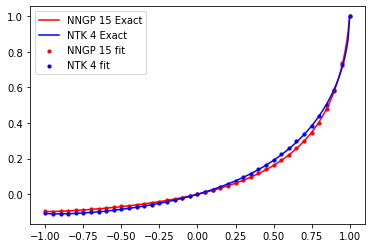

In [ ]:
xis = np.linspace(1, -1, 201)
half = 100
_, exactNNGP15ReLU = get_infinite_width_K_coeffs(dataset_cifar10, 20, 'nngp', 15, 'relu', n_sample_points=201, weight_on_endpoints=0)
coeffs1, _ = get_infinite_width_K_coeffs(dataset_cifar10, 20, 'nngp', 15, 'relu', n_sample_points=1000, weight_on_endpoints=0.1)
_, exactNTK4ReLU = get_infinite_width_K_coeffs(dataset_cifar10, 20, 'ntk', 4, 'relu', n_sample_points=201, weight_on_endpoints=0)
coeffs2, _ = get_infinite_width_K_coeffs(dataset_cifar10, 20, 'ntk', 4, 'relu', n_sample_points=1000, weight_on_endpoints=0.1)

plt.plot(xis, (exactNNGP15ReLU - exactNNGP15ReLU[half]) / (exactNNGP15ReLU[0] - exactNNGP15ReLU[half]), color='r', label='NNGP 15 Exact')
plt.plot(xis, (exactNTK4ReLU - exactNTK4ReLU[half]) / (exactNTK4ReLU[0] - exactNTK4ReLU[half]), color='b', label='NTK 4 Exact')
plt.scatter(xis[::5], eval(poly_coeffs_to_lambda_fn_string((coeffs1 - coeffs1[0]*np.pad(np.ones(1), (0, 20), 'constant', constant_values=(0)))/np.sum(coeffs1[1:]), factorials=False))(xis[::5]), c='r', s=10, label='NNGP 15 fit')
plt.scatter(xis[::5], eval(poly_coeffs_to_lambda_fn_string((coeffs2 - coeffs2[0]*np.pad(np.ones(1), (0, 20), 'constant', constant_values=(0)))/np.sum(coeffs2[1:]), factorials=False))(xis[::5]), c='b', s=10, label='NTK 4 fit')

plt.legend()
plt.show()

In [ ]:
with open('infinite_kernels_cifar10.pkl', 'wb') as f:
  pickle.dump({'unoptimized': infinite_kernels, 'optimized': optimized_infinite_kernels, 'NNGP_15_ReLU_201': exactNNGP15ReLU, 'NTK_4_ReLU_201': exactNTK4ReLU}, f)

Calculate mean and averages

In [ ]:
random_unoptimized_loss = np.asarray([a[1] for a in random_kernels])
random_unoptimized_acc = np.asarray([a[2] for a in random_kernels])
random_optimized_loss = np.asarray([a[1] for a in optimized_kernels])
random_optimized_acc = np.asarray([a[2] for a in optimized_kernels])


In [ ]:
print(r'{:9.5f}'.format(np.mean(random_unoptimized_loss)) + r'$\pm$' + r'{:9.5f}'.format(np.std(random_unoptimized_loss)))
print(r'{:7.2f}'.format(np.mean(random_unoptimized_acc)) + r'$\pm$' + r'{:7.2f}'.format(np.std(random_unoptimized_acc)))
print(r'{:9.5f}'.format(np.mean(random_optimized_loss)) + r'$\pm$' + r'{:9.5f}'.format(np.std(random_optimized_loss)))
print(r'{:7.2f}'.format(np.mean(random_optimized_acc)) + r'$\pm$' + r'{:7.2f}'.format(np.std(random_optimized_acc)))

  0.37726$\pm$  0.03012
  45.76$\pm$   2.97
  0.33612$\pm$  0.00002
  49.73$\pm$   0.05


#Plotting Optimization Results

In [ ]:
#Load the pickle files
with open('random_kernels_cifar10.pkl', 'rb') as f:
  data = pickle.load(f)
random_kernels = data['unoptimized']
optimized_kernels = data['optimized']

with open('infinite_kernels_cifar10.pkl', 'rb') as f:
  data = pickle.load(f)
infinite_kernels = data['unoptimized']
optimized_infinite_kernels = data['optimized']
exactNNGP15ReLU = data['NNGP_15_ReLU_201']
exactNTK4ReLU = data['NTK_4_ReLU_201']

##Initial Kernels
We remove the 0th order polynomial (constant) and divide the remaining coefficients by the sum of coefficients.

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0347 0.     0.5812 0.     0.     0.     0.     0.     0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0563 0.     0.9437 0.     0.     0.     0.     0.     0.    ]
[0.     0.     0.     0.     0.2751 0.     0.     0.     0.     0.     0.     0.     0.     0.7461 0.     0.     0.     0.     0.     0.2161 0.    ]
[0.     0.     0.     0.     0.2224 0.     0.     0.     0.     0.     0.     0.     0.     0.603  0.     0.     0.     0.     0.     0.1747 0.    ]
[0.8295 0.     0.962  0.4819 0.     0.     0.     0.     0.     0.     0.     0.8662 0.     0.4132 0.     0.     0.     0.3481 0.956  0.     0.    ]
[0.     0.     0.2389 0.1197 0.     0.     0.     0.     0.     0.     0.     0.2151 0.     0.1026 0.     0.     0.     0.0864 0.2374 0.     0.    ]
[0.     0.     0.     0.     0.     0.0905 0.8576 0.     0.     0.     0.     0.     0.     0.8778 0.     

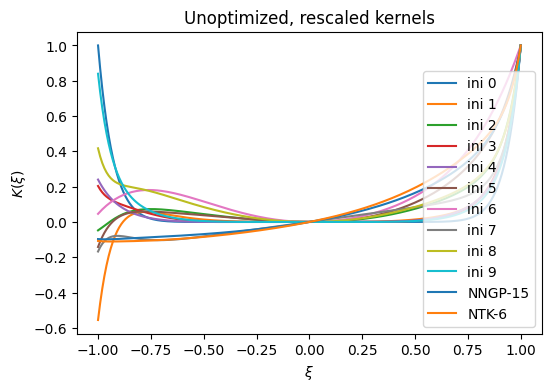

In [ ]:
xis = np.linspace(-1, 1, 201)
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
for i, ket_set in enumerate(random_kernels):
  ker = copy(ket_set[0])
  print(ker)
  ker[0] = 0
  ker = ker / np.sum(ker)
  print(ker)
  ker_func = eval(poly_coeffs_to_lambda_fn_string(ker, factorials=False))
  Ks = ker_func(xis)
  ax.plot(xis, Ks, label='ini ' + str(i))

for ket_set, lab in zip(infinite_kernels, ['NNGP-15', 'NTK-6']):
  ker = copy(ket_set[0])
  print(ker)
  ker[0] = 0
  ker = ker / np.sum(ker)
  print(ker)
  ker_func = eval(poly_coeffs_to_lambda_fn_string(ker, factorials=False))
  Ks = ker_func(xis)
  ax.plot(xis, Ks, label=lab)

ax.set_title('Unoptimized, rescaled kernels')
ax.set_xlabel(r'$\xi$')
ax.set_ylabel(r'$K(\xi)$')
ax.legend()

##Optimized kernels

[1.3327 0.349  1.02   0.6356 0.7148 0.0901 0.3662 0.1361 0.1191 0.1967 0.     0.2076 0.     0.2059 0.5164 0.2109 0.0133 0.237  0.1121 0.2782 0.2233]
[0.     0.062  0.1811 0.1128 0.1269 0.016  0.065  0.0242 0.0211 0.0349 0.     0.0369 0.     0.0366 0.0917 0.0374 0.0024 0.0421 0.0199 0.0494 0.0396]
[2.3669 0.5111 1.4678 0.9019 1.0056 0.1951 0.5011 0.1444 0.2975 0.1623 0.1523 0.1527 0.0739 0.9029 0.08   0.1696 0.1386 0.2031 0.221  0.4702 0.3336]
[0.     0.0632 0.1816 0.1116 0.1244 0.0241 0.062  0.0179 0.0368 0.0201 0.0188 0.0189 0.0091 0.1117 0.0099 0.021  0.0171 0.0251 0.0273 0.0582 0.0413]
[0.8264 0.3214 0.9104 0.5785 0.5766 0.0884 0.4037 0.0139 0.1732 0.0033 0.     0.744  0.     0.2537 0.     0.     0.     0.1624 0.7704 0.     0.    ]
[0.     0.0643 0.1821 0.1157 0.1153 0.0177 0.0807 0.0028 0.0346 0.0007 0.     0.1488 0.     0.0507 0.     0.     0.     0.0325 0.1541 0.     0.    ]
[3.6127 0.2828 0.8511 0.4871 0.2527 0.1823 0.8386 0.0099 0.     0.0274 0.     0.0312 0.     0.8067 0.     

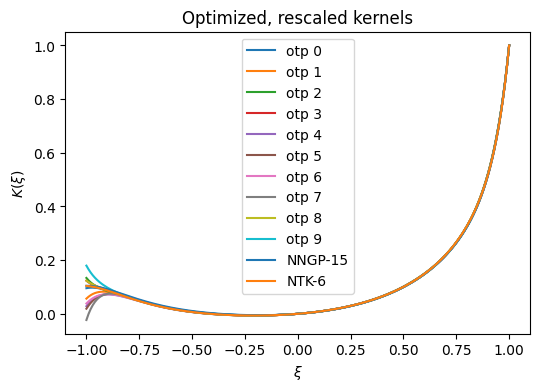

In [ ]:
xis = np.linspace(-1, 1, 201)
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
for i, ket_set in enumerate(optimized_kernels):
  ker = copy(ket_set[0])
  print(ker)
  ker[0] = 0
  ker = ker / np.sum(ker)
  print(ker)
  ker_func = eval(poly_coeffs_to_lambda_fn_string(ker, factorials=False))
  Ks = ker_func(xis)
  ax.plot(xis, Ks, label='otp ' + str(i))

for ket_set, lab in zip(optimized_infinite_kernels, ['NNGP-15', 'NTK-6']):
  ker = copy(ket_set[0])
  print(ker)
  ker[0] = 0
  ker = ker / np.sum(ker)
  print(ker)
  ker_func = eval(poly_coeffs_to_lambda_fn_string(ker, factorials=False))
  Ks = ker_func(xis)
  ax.plot(xis, Ks, label=lab)

ax.set_title('Optimized, rescaled kernels')
ax.set_xlabel(r'$\xi$')
ax.set_ylabel(r'$K(\xi)$')
ax.legend()

##Figure 3

Test, shallow      	  loss:   0.33611 			acc:   49.67 			ce:    2.09
Test, shallow      	  loss:   0.33677 			acc:   49.63 			ce:    2.09
Test, shallow      	  loss:   0.33613 			acc:   49.69 			ce:    2.09
Test, shallow      	  loss:   0.33678 			acc:   49.63 			ce:    2.09
Test, shallow      	  loss:   0.33615 			acc:   49.69 			ce:    2.09
Test, shallow      	  loss:   0.33681 			acc:   49.67 			ce:    2.09
Test, shallow      	  loss:   0.33616 			acc:   49.78 			ce:    2.09
Test, shallow      	  loss:   0.33680 			acc:   49.72 			ce:    2.09
Test, shallow      	  loss:   0.33611 			acc:   49.77 			ce:    2.09
Test, shallow      	  loss:   0.33677 			acc:   49.74 			ce:    2.09
Test, shallow      	  loss:   0.33616 			acc:   49.79 			ce:    2.09
Test, shallow      	  loss:   0.33681 			acc:   49.72 			ce:    2.09
Test, shallow      	  loss:   0.33612 			acc:   49.72 			ce:    2.09
Test, shallow      	  loss:   0.33678 			acc:   49.67 			ce:    2.09
Test, shallow      	  loss:   0.33

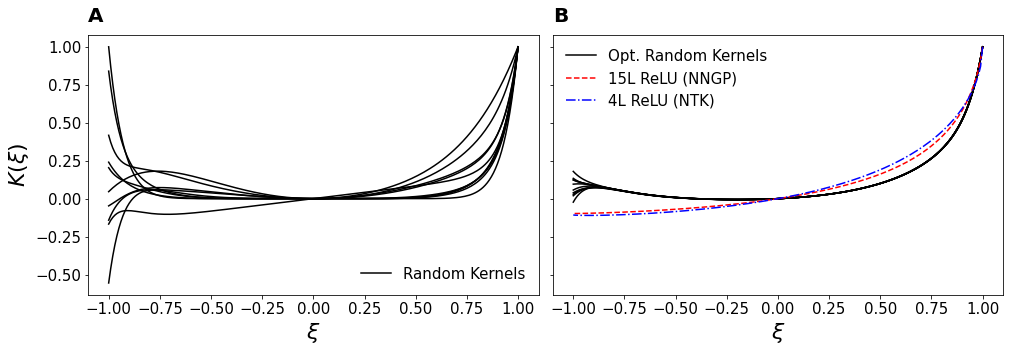

In [ ]:
colors = ['r', 'b']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
axs[0].get_shared_y_axes().join(axs[0], axs[1])

ax = axs[0]
xis = np.linspace(-1, 1, 201)
for i, ket_set in enumerate(random_kernels):
  ker = copy(ket_set[0])
  ker[0] = 0
  ker = ker / np.sum(ker)
  ker_func = eval(poly_coeffs_to_lambda_fn_string(ker, factorials=False))
  Ks = ker_func(xis)
  if i == 0:
    ax.plot(xis, Ks, label='Random Kernels', color='k')
  else:
    ax.plot(xis, Ks, color='k')

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r'$\xi$', fontsize=22)
ax.set_ylabel(r'$K(\xi)$', fontsize=22)
ax.legend(prop=dict(size=15), frameon=False, loc='lower right')

ax = axs[1]
xis = np.linspace(-1, 1, 201)
for i, ket_set in enumerate(optimized_kernels):
  ker = copy(ket_set[0])
  kernel_parameters_to_valmetric(ker, dataset_cifar10, 0, True)
  ker[0] = 0
  ker = ker / np.sum(ker)
  kernel_parameters_to_valmetric(ker, dataset_cifar10, 0, True)

  ker_func = eval(poly_coeffs_to_lambda_fn_string(ker, factorials=False))
  Ks = ker_func(xis)
  if i == 0:
    ax.plot(xis, Ks, label='Opt. Random Kernels', color='k')
  else:
    ax.plot(xis, Ks, color='k')

'''
# Polynomial approximation to the infinite width kernels
for i, data_set in enumerate(zip(infinite_kernels, ['15L ReLU (NNGP)', '4L ReLU (NTK)'], ['--', '-.'])):
  ket_set, lab, line = data_set
  ker = copy(ket_set[0])
  kernel_parameters_to_valmetric(ker, dataset_cifar10, 0, True)
  ker[0] = 0
  ker = ker / np.sum(ker)
  kernel_parameters_to_valmetric(ker, dataset_cifar10, 0, True)

  ker_func = eval(poly_coeffs_to_lambda_fn_string(ker, factorials=False))
  Ks = ker_func(xis)
  ax.plot(xis, Ks, label=lab, color=colors[i], linestyle=line)
'''
# Instead of polynomial approximations, use the exact kernels to better capture the infinite slope at $\xi = 1$ for the NTK kernel.
ax.plot(xis[::-1], (exactNNGP15ReLU - exactNNGP15ReLU[100]) / (exactNNGP15ReLU[0] - exactNNGP15ReLU[100]), color='r', label='15L ReLU (NNGP)', linestyle='--')
ax.plot(xis[::-1], (exactNTK4ReLU - exactNTK4ReLU[100]) / (exactNTK4ReLU[0] - exactNTK4ReLU[100]), color='b', label='4L ReLU (NTK)', linestyle='-.')

ax.set_xlabel(r'$\xi$', fontsize=22)
ax.set_yticklabels([])
ax.tick_params(axis='both', which='major', labelsize=15)

ax.legend(prop=dict(size=15), frameon=False, loc='upper left')
axs[0].text(0, 1.05, 'A', transform=axs[0].transAxes, size=20, weight='bold')
axs[1].text(0, 1.05, 'B', transform=axs[1].transAxes, size=20, weight='bold')

fig.tight_layout()

plt.savefig('fig3.png', transparent=True, dpi=300, bbox_inches='tight')

Does loss/accuracy have some correlation with the coeffs[0] (the constant term in the kernel polynomial)? No, neither do.

Test, shallow      	  loss:   0.33611 			acc:   49.67 			ce:    2.09
Test, shallow      	  loss:   0.33612 			acc:   49.69 			ce:    2.09
Test, shallow      	  loss:   0.33615 			acc:   49.69 			ce:    2.09
Test, shallow      	  loss:   0.33616 			acc:   49.78 			ce:    2.09
Test, shallow      	  loss:   0.33611 			acc:   49.77 			ce:    2.09
Test, shallow      	  loss:   0.33616 			acc:   49.79 			ce:    2.09
Test, shallow      	  loss:   0.33612 			acc:   49.72 			ce:    2.09
Test, shallow      	  loss:   0.33612 			acc:   49.77 			ce:    2.09
Test, shallow      	  loss:   0.33610 			acc:   49.67 			ce:    2.09
Test, shallow      	  loss:   0.33610 			acc:   49.79 			ce:    2.09


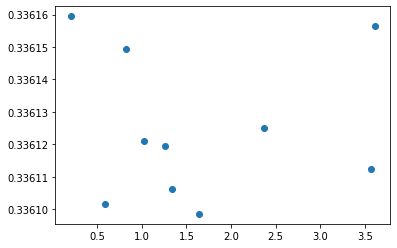

In [ ]:
constants = []
losses=[]
for ker_set in optimized_kernels:
  ker = copy(ker_set[0])
  loss, acc = kernel_parameters_to_valmetric(ker, dataset_cifar10, 0, True)
  constants.append(ker[0])
  losses.append(loss)

plt.figure()
plt.scatter(constants, losses)

## Before and after performance

Visually look at loss and accuracy before and after optimization.

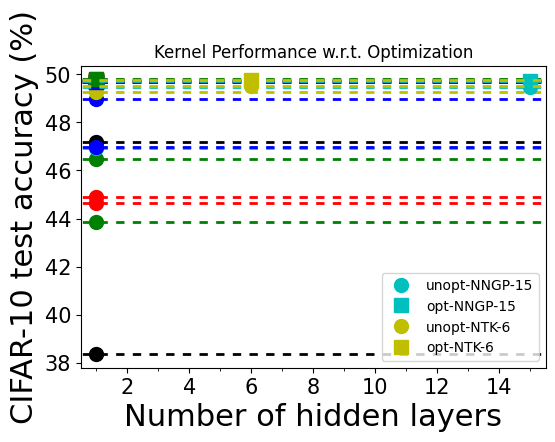

In [ ]:
xis = np.linspace(-1, 1, 200)
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
kwargs = {'lw':3, 'markersize':10}
colors = ['k','r','b','g','c','y'] #[(0,.5,.5), (0,.2,.2), (.7,0,0), (.2,0,0), (0,.6,0), (0,0,.7)]
for i, ker_set in enumerate(zip(random_kernels, optimized_kernels)):
  unopt_acc = ker_set[0][2]
  opt_acc = ker_set[1][2]

  ax.plot([1], [unopt_acc], 'o', color=colors[i % len(colors)], **kwargs)
  ax.plot([-100,100], [unopt_acc]*2, lw=2, linestyle=(0,(3,3)), color=colors[i % len(colors)])

  ax.plot([1], [opt_acc], 's', color=colors[i % len(colors)], **kwargs)
  ax.plot([-100,100], [opt_acc]*2, lw=2, linestyle=(0,(3,3)), color=colors[i % len(colors)])

for i, data_set in enumerate(zip(zip(infinite_kernels, optimized_infinite_kernels), ['NNGP-15', 'NTK-6'], [15, 6])):
  ker_set = data_set[0]
  lab = data_set[1]
  depth = data_set[2]

  unopt_acc = ker_set[0][2]
  opt_acc = ker_set[1][2]

  ax.plot([depth], [unopt_acc], 'o', color=colors[i+len(optimized_kernels) % len(colors)], label='unopt-' + lab, **kwargs)
  ax.plot([-100,100], [unopt_acc]*2, lw=2, linestyle=(0,(3,3)), color=colors[i+len(optimized_kernels) % len(colors)])

  ax.plot([depth], [opt_acc], 's', color=colors[i+len(optimized_kernels) % len(colors)], label='opt-' + lab, **kwargs)
  ax.plot([-100,100], [opt_acc]*2, lw=2, linestyle=(0,(3,3)), color=colors[i+len(optimized_kernels) % len(colors)])

ax.set_title('Kernel Performance w.r.t. Optimization')
ax.set_xlabel('Number of hidden layers', fontsize=22)
ax.set_ylabel('CIFAR-10 test accuracy (%)', fontsize=22)
ax.set_xticks(list([i for i in range(2,20,2)]), minor=False)
ax.set_xticks(list([i for i in range(1,20,2)]), minor=True)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlim(.5, 15.5)

ax.legend(loc='best')

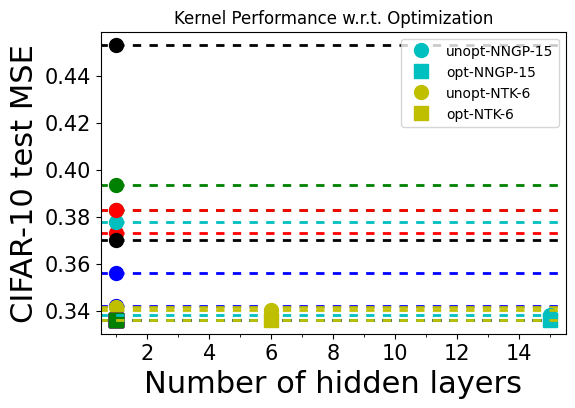

In [ ]:
xis = np.linspace(-1, 1, 200)
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
kwargs = {'lw':3, 'markersize':10}
colors = ['k','r','b','g','c','y'] #[(0,.5,.5), (0,.2,.2), (.7,0,0), (.2,0,0), (0,.6,0), (0,0,.7)]
for i, ker_set in enumerate(zip(random_kernels, optimized_kernels)):
  unopt_acc = ker_set[0][1]
  opt_acc = ker_set[1][1]

  #ax.plot([1], [unopt_acc], 'o', color=colors[i], label='ini' + str(i), **kwargs)
  ax.plot([1], [unopt_acc], 'o', color=colors[i % len(colors)], **kwargs)
  ax.plot([-100,100], [unopt_acc]*2, lw=2, linestyle=(0,(3,3)), color=colors[i % len(colors)])

  #ax.plot([1], [opt_acc], 's', color=colors[i], label='opt' + str(i), **kwargs)
  ax.plot([1], [opt_acc], 's', color=colors[i % len(colors)], **kwargs)
  ax.plot([-100,100], [opt_acc]*2, lw=2, linestyle=(0,(3,3)), color=colors[i % len(colors)])

for i, data_set in enumerate(zip(zip(infinite_kernels, optimized_infinite_kernels), ['NNGP-15', 'NTK-6'], [15, 6])):
  ker_set = data_set[0]
  lab = data_set[1]
  depth = data_set[2]

  unopt_acc = ker_set[0][1]
  opt_acc = ker_set[1][1]

  ax.plot([depth], [unopt_acc], 'o', color=colors[i+len(optimized_kernels) % len(colors)], label='unopt-' + lab, **kwargs)
  ax.plot([-100,100], [unopt_acc]*2, lw=2, linestyle=(0,(3,3)), color=colors[i+len(optimized_kernels) % len(colors)])

  ax.plot([depth], [opt_acc], 's', color=colors[i+len(optimized_kernels) % len(colors)], label='opt-' + lab, **kwargs)
  ax.plot([-100,100], [opt_acc]*2, lw=2, linestyle=(0,(3,3)), color=colors[i+len(optimized_kernels) % len(colors)])

ax.set_title('Kernel Performance w.r.t. Optimization')
ax.set_xlabel('Number of hidden layers', fontsize=22)
ax.set_ylabel('CIFAR-10 test MSE', fontsize=22)
ax.set_xticks(list([i for i in range(2,20,2)]), minor=False)
ax.set_xticks(list([i for i in range(1,20,2)]), minor=True)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlim(.5, 15.5)

ax.legend(loc='best')